In [1]:
%load_ext autoreload
%autoreload 2
%run ./initializer

Added the path (/Users/madalenabarcelo/Desktop/BA/DMT/DataMiningTechniquesA1) to sys.path


In [2]:
from random_forest_classifier_2a import RandomForestMoodModel, plot_predicted_vs_actual
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from data_loading import DataPreprocessor
from random_forest_classifier_2a import split_train_val_per_id


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/local/Cellar/python@3.10/3.10.16/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/local/Cellar/python@3.10/3.10.16/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/madalenabarcelo/Desktop/BA/DMT/DataMiningTechniquesA1/notebooks/.venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.lau

In [3]:
data_loader = DataPreprocessor()
train_df, test_df = data_loader.load_and_preprocess_data("1d", 0.5, 1, for_RNN_model=False)

Removed 53 outliers from 1268 observations. Percentage: 4.18%


In [8]:
# 1. Prepare features and labels, filtering rare classes
label_counts = train_df['mood'].value_counts()
valid_labels = label_counts[label_counts >= 2].index
train_df_filtered = train_df[train_df['mood'].isin(valid_labels)]

# Keep date column for evaluation
dates = train_df_filtered['date']

# Then drop id, mood, and date for features
features = train_df_filtered.drop(columns=['id', 'mood', 'date'])
labels = train_df_filtered['mood']

# 2. Use split_train_val_per_id to split data
train_user_df, val_user_df = split_train_val_per_id(train_df_filtered, val_frac=0.2)

# Prepare training and validation data for the model
X_train = train_user_df.drop(columns=["id", "mood", "date"])
y_train = train_user_df["mood"]
X_val = val_user_df.drop(columns=["id", "mood", "date"])
y_val = val_user_df["mood"]

# Also save dates for validation set for evaluation
dates_val = val_user_df['date']

# 3. Train the classifier with class weights
model = RandomForestMoodModel(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# 4. Evaluate on validation set
val_preds = model.predict(X_val)
print("\nValidation Report:")
print(classification_report(y_val, val_preds))

# 5. Evaluate daily average performance
rmse, mean_error = model.evaluate_daily_average_performance(y_val, val_preds, dates_val)
print("Daily average RMSE:", rmse)
print("Mean Error:", mean_error)

# 6. Predict on test set
X_test = test_df.drop(columns=['id', 'mood', 'date'])
test_preds = model.predict(X_test)

# 7. Attach predictions
test_df_with_preds = test_df.copy()
test_df_with_preds['predicted_mood_class'] = test_preds

# 8. Output predictions
print(test_df_with_preds[['id', 'predicted_mood_class']])



Validation Report:
              precision    recall  f1-score   support

           7       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         3
          11       0.00      0.00      0.00        13
          12       0.40      0.08      0.13        25
          13       0.38      0.11      0.17        28
          14       0.41      0.90      0.56       102
          15       0.18      0.06      0.09        34
          16       0.50      0.03      0.05        38
          17       0.00      0.00      0.00         3
          18       0.00      0.00      0.00         3

    accuracy                           0.40       250
   macro avg       0.19      0.12      0.10       250
weighted avg       0.35      0.40      0.28       250

Daily average RMSE: 1.155661825899958
Mean Error: -0.2763623615267214
         id  predicted_mood_class
0   AS14.01                    14
1   AS14.02                    14
2   AS14.03                    14
3   AS14.05    

/Users/madalenabarcelo/Desktop/BA/DMT/DataMiningTechniquesA1/notebooks/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/madalenabarcelo/Desktop/BA/DMT/DataMiningTechniquesA1/notebooks/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/madalenabarcelo/Desktop/BA/DMT/DataMiningTechniquesA1/notebooks/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no

Daily average RMSE: 1.155661825899958
Mean Error: -0.2763623615267214


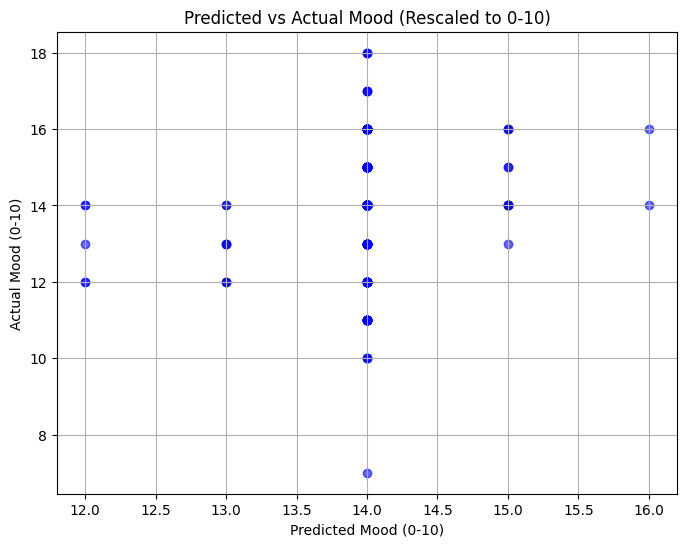

In [9]:
rmse, mean_error = model.evaluate_daily_average_performance(y_val, val_preds, dates_val)
print("Daily average RMSE:", rmse)
print("Mean Error:", mean_error)

plot_predicted_vs_actual(y_val, val_preds)